**Convolutional neural network (CNN)**, a class of artificial neural networks that has become dominant in various computer vision tasks, is attracting interest across a variety of domains, including radiology. CNN is designed to automatically and adaptively learn spatial hierarchies of features through backpropagation by using multiple building blocks, such as convolution layers, pooling layers, and fully connected layers. This review article offers a perspective on the basic concepts of CNN and its application to various radiological tasks, and discusses its challenges and future directions in the field of radiology. Two challenges in applying CNN to radiological tasks, small dataset and overfitting, will also be covered in this article, as well as techniques to minimize them. Being familiar with the concepts and advantages, as well as limitations, of CNN is essential to leverage its potential in diagnostic radiology, with the goal of augmenting the performance of radiologists and improving patient care.



CNN is a type of deep learning model for processing data that has a grid pattern, such as images, which is inspired by the organization of animal visual cortex. and designed to automatically and adaptively learn spatial hierarchies of features, from low- to high-level patterns. CNN is a mathematical construct that is typically composed of three types of layers (or building blocks): convolution, pooling, and fully connected layers. The first two, convolution and pooling layers, perform feature extraction, whereas the third, a fully connected layer, maps the extracted features into final output, such as classification. A convolution layer plays a key role in CNN, which is composed of a stack of mathematical operations, such as convolution, a specialized type of linear operation. In digital images, pixel values are stored in a two-dimensional (2D) grid, i.e., an array of numbers (Fig. 2), and a small grid of parameters called kernel, an optimizable feature extractor, is applied at each image position, which makes CNNs highly efficient for image processing, since a feature may occur anywhere in the image. As one layer feeds its output into the next layer, extracted features can hierarchically and progressively become more complex. The process of optimizing parameters such as kernels is called training, which is performed so as to minimize the difference between outputs and ground truth labels through an optimization algorithm called backpropagation and gradient descent, among others.

First, CNN does not require hand-crafted feature extraction. Second, CNN architectures do not necessarily require segmentation of tumors or organs by human experts. Third, CNN is far more data hungry because of its millions of learnable parameters to estimate, and, thus, is more computationally expensive, resulting in requiring graphical processing units (GPUs) for model training.

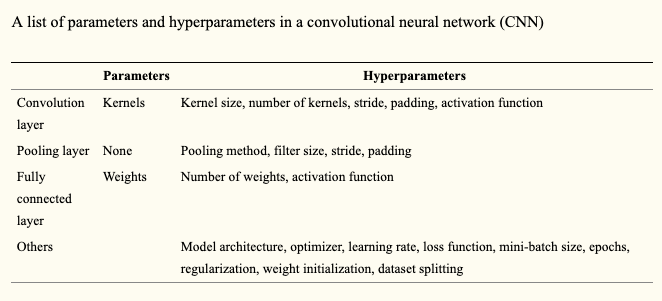

# Building blocks of CNN architecture

The CNN architecture includes several building blocks, such as convolution layers, pooling layers, and fully connected layers. A typical architecture consists of repetitions of a stack of several convolution layers and a pooling layer, followed by one or more fully connected layers.

In [28]:
# !pip install tensorflow
# !pip install keras

In [29]:
import os
import numpy as np
import pandas as pd
import math

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Conv2D, Flatten, Concatenate
from keras.preprocessing.image import ImageDataGenerator

from contextlib import redirect_stdout
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

#import for Xception
from tensorflow.python.keras.applications import InceptionV3, Xception
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam
from tqdm import tqdm

In [30]:
path = "/home/crestle/amliNet/CheXpert-v1.0-small"
target = "Support Devices"
image_size = 320

train_batch_size = 32
val_batch_size = 32
test_batch_size = 234

train_set_size = 10000

lr = 0.0001 #learning rate
num_steps_per_epoch = None #can be set to none for auto choosing
num_epochs = 1

threshold = 0.5

#create the directory before you start!
model_name = 'Xception'
model_directory = model_name+'/' 
if os.path.isdir(model_directory):
    print('Did you mean to rename the model?')
else:
    os.makedirs(model_directory)

Did you mean to rename the model?


In [31]:
#function to replace urls
def edit_urls(url):
    pieces = url.split('/')
    newurl=''
    for i, piece in enumerate(pieces):
        if i>0:
            newurl += '/' + piece
        elif i==0:
            newurl += path
    return newurl

# read csv files
train_df = pd.read_csv(path + "/train.csv")
train_df = train_df.sample(1000)
test_df = pd.read_csv(path + "/test.csv")

# fill missing values and replace -1 with 1
train_df = train_df.fillna(0)
train_df = train_df.replace(-1, 1)

# appry URL function to change urls to be able to read images
train_df["Path"] = train_df["Path"].apply(edit_urls)
test_df["Path"] = test_df["Path"].apply(edit_urls)

#for KERAS target value has to be a string
train_df[target] = train_df[target].apply(str)
test_df[target] = test_df[target].apply(str)

In [37]:
datagen=ImageDataGenerator(rescale=1./255, #scale the color information to 0 to 1 instead of 0 to 255
                           #horizontal_flip=True,
                           #zoom_range=0.10, #Range for random zoom
                          # rotation_range = 5, #Degree range for random rotations.
                           validation_split=0.1) 

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col=target,
    color_mode='grayscale', # images will be converted to have 1 color channel
    target_size=(image_size, image_size), #The dimensions to which all images found will be resized
    class_mode='binary', # Mode for yielding the targets 1D numpy array of binary labels,if class_mode is "binary" it must include the given y_col column with class values as strings.
    batch_size=train_batch_size,
    subset = "training"
    #shuffle: whether to shuffle the data (default: True)
)

validation_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col=target,
    target_size=(image_size, image_size, 1),
    color_mode='grayscale',
    class_mode='binary', 
    batch_size=val_batch_size,
    subset = "validation"
)

test_generator = datagen.flow_from_dataframe(
    test_df, 
    x_col='Path',
    y_col=target,
    target_size=(image_size, image_size, 1),
    #color_mode='grayscale',
    color_mode='rgb',
    class_mode='binary', 
    batch_size=test_batch_size
)

Found 900 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 234 validated image filenames belonging to 2 classes.


# ResNet

In [38]:
from keras import applications
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D

resnet_model = applications.resnet50.ResNet50(weights=None, include_top=False, input_shape= (320,320,1))
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.1)(x)

predictions = Dense(1, activation= 'sigmoid')(x)
model = Model(inputs = resnet_model.input, outputs = predictions)


adam = Adam(lr=0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


# Xception

In [20]:

# xception_model = Xception(input_shape =(320,320,1), include_top = False, weights = None)

# x = xception_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.1)(x)

# predictions = Dense(1, activation= 'sigmoid')(x)
# model = Model(inputs = resnet_model.input, outputs = predictions)


# adam = Adam(lr=0.0001)
# model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])
# print(model.summary()) 

# DenseNet (change "rgb" in datagenerator) does not work

In [24]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
# from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Flatten
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import Sequence
# #from tensorflow.keras_contrib.applications.densenet import DenseNetImageNet121
# from tensorflow.keras.applications.densenet import DenseNet121

# base_model = DenseNet121(input_shape=(320, 320, 3),
#                              weights='imagenet',
#                              include_top=False,
#                              pooling='avg')

# x = base_model.output
# x = Dense(5, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid', name="final_classifier")(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# adam = Adam(lr=0.0001)
# model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=32,
                              epochs=10,
                              validation_data=test_generator,
                              validation_steps=100)

Epoch 1/10
31/32 [============================>.] - ETA: 23s - loss: 0.7758 - acc: 0.5696

# Access Model Training History in Keras

Keras provides the capability to register callbacks when training a deep learning model.

One of the default callbacks that is registered when training all deep learning models is the History callback. It records training metrics for each epoch. This includes the loss and the accuracy (for classification problems) as well as the loss and accuracy for the validation dataset, if one is set.

The history object is returned from calls to the fit() function used to train the model. Metrics are stored in a dictionary in the history member of the object returned.

In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


The plots can provide an indication of useful things about the training of the model, such as:

It’s speed of convergence over epochs (slope).
Whether the model may have already converged (plateau of the line).
Whether the mode may be over-learning the training data (inflection for validation line).

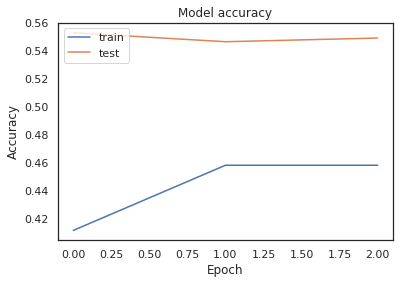

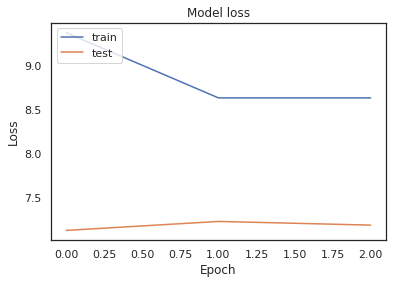

In [28]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the plot of accuracy we can see that the model could probably be trained a little more as the trend for accuracy on both datasets is still rising for the last few epochs. We can also see that the model has not yet over-learned the training dataset, showing comparable skill on both datasets.

From the plot of loss, we can see that the model has comparable performance on both train and validation datasets (labeled test). If these parallel plots start to depart consistently, it might be a sign to stop training at an earlier epoch.

# Make Predictions

In [30]:
predictions = model.predict_generator(test_generator, steps = len(test_generator))
print(f'made {len(predictions)} predictions')

# This checks the row that is related to 'being sick' (... hopefully)
probability_sick = predictions.T[0]
print(probability_sick[0:10].round())
actual_labels = test_generator[0][1]
print(actual_labels[0:10])

made 234 predictions
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0.]


# Confusion matrix

In [ ]:
def get_confusion_matrix(predictions, actuals, threshold):
    """
    Returns a confusion matrix whose rows correspond to predicted outputs and
       whose columns correspond to actual outputs.

    predictions: 1D numpy array.
    actuals: 1D numpy array.
    threshold: float, value above which predictions are classified as positive,
       below which predictions are classified as negative.
    """
    bool_predictions = (predictions > threshold)
    bool_actuals = (actuals > threshold)

    return confusion_matrix(bool_predictions, bool_actuals)

**True Positive** — Label which was predicted Positive (in our scenario Authenticated Bank Notes) and is actually Positive (i.e. belong to Positive ‘Authorized’ Class).

**True Negative** — Label which was predicted Negative (in our scenario Forged Bank Notes) and is actually Negative (i.e. belong to Negative ‘Forged’ Class).

**False Positive** — Label which was predicted as Positive, but is actually Negative, or in simple words the Note wrongly predicted as Authentic by our Model, but is actually Forged. In Hypothesis Testing it is also known as Type 1 error or the incorrect rejection of Null Hypothesis, refer this to read more about Hypothesis testing.

**False Negatives** — Labels which was predicted as Negative, but is actually Positive (Authentic Note predicted as Forged). It is also known as Type 2 error, which leads to the failure in rejection of Null Hypothesis.

Now lets look at most common evaluation metrics every Machine Learning Practitioner should know!
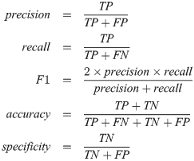



In [ ]:
def get_metrics(predictions, actuals, threshold):
    """
    Prints all metrics associated with the model output.

    predictions: 1D numpy array.
    actuals: 1D numpy array.
    threshold: float, value above which predictions are classified as positive,
       below which predictions are classified as negative.
    """
    TP, FP, FN, TN = get_confusion_matrix(predictions, actuals, threshold).ravel()

    trues = TP + TN
    wrongs = FP + FN
    sensitivity = TP / (TP + FN) # This is also recall
    specificity = TN / (TN + FP)
    precision = TP / (TP +FP)
    accuracy = (TP + TN) / (TP + TN + FP +FN)
    F1 = 2 / ((1 / precision) + (1 / sensitivity))
    
    metrics_df = pd.DataFrame()
    metrics_df['Correct Predictions'] = [trues]
    metrics_df['Incorrect Predictions'] = [wrongs]
    metrics_df['Sensitivity'] = [sensitivity]
    metrics_df['Specificity'] = [specificity]
    metrics_df['Precision'] = [precision]
    metrics_df['Accuracy'] = [accuracy]
    metrics_df['F1 score'] = [F1]
    metrics_df.index = [model_name]
    metrics_df
    t = metrics_df.transpose()
    t.to_csv(model_directory+'metrics.csv')
    display(t)
    
    return

How Accurate is our Model?

Does Accuracy matter?
Not always, it may not be the right measure at times, especially if your Target class is not balanced (data is skewed). Then you may consider additional metrics like Precision, Recall, F score (combined metric), but before diving in lets take a step back and understand the terms that form the basis for these.

Precision

It is the ‘Exactness’, ability of the model to return only relevant instances. If your use case/problem statement involves minimizing the False Positives, i.e. in current scenario if you don’t want the Forged Notes to be labelled as Authentic by the Model then Precision is something you need.

Recall

It is the ‘Completeness’, ability of the model to identify all relevant instances, True Positive Rate, aka Sensitivity. In the current scenario if your focus is to have the least False Negatives i.e. you don’t Authentic Notes to be wrongly classified as Forged then Recall can come to your rescue.

F1 Measure

Harmonic mean of Precision & Recall, used to indicate a balance between Precision & Recall providing each equal weightage, it ranges from 0 to 1. F1 Score reaches its best value at 1 (perfect precision & recall) and worst at 0, read more here.

Specificity

It is also referred to as ‘True Negative Rate’ (Proportion of actual negatives that are correctly identified), i.e. more True Negatives the data hold the higher its Specificity.

In [ ]:
def get_roc_curve(predictions, actuals):
    """
    Plots the ROC curve and associated AUC of the model output.

    predictions: 1D numpy array.
    actuals: 1D numpy array.
    """
    FPR, TPR, thresholds = roc_curve(actuals, predictions)
    AUC = roc_auc_score(actuals, predictions)

    plt.plot(FPR, TPR, "b-")
    plt.plot([0, 1], [0, 1], "r--")
    plt.title("Receiver Operating Characteristic \n AUC: {}".format(AUC))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel("Sensitivity")
    plt.xlabel("1 - Specificity")
    plt.savefig(model_directory+'ROC_curve.png')
    plt.show()
    
    return

In [ ]:
def get_precision_recall_curve(predictions, actuals):
    """
    Plots the precision-recall curve and associated AUC of the model output.

    predictions: 2D numpy array.
    actuals: 1D numpy array.
    """
    precisions, recalls, thresholds = precision_recall_curve(actuals, predictions)
    AUC = auc(recalls, precisions)

    plt.plot(recalls, precisions, "b-")
    plt.plot([0, 1], [1, 0], "r--")
    plt.title("Precision-Recall Curve \n AUC: {}".format(AUC))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    plt.savefig(model_directory+'precision_recall_curve.png')
    plt.show()
    
    return 'saved precision recall curve'


In [ ]:
def display_conf_mat(predictions, actuals, threshold):
    '''
    Displays and saves the confusion matrix
    '''
    cm = get_confusion_matrix(predictions, actuals, threshold)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap=plt.cm.Blues,fmt='g') #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.savefig(model_directory + 'confusion_matrix.png')
    plt.show()
    
    return 'saved confusion matrix'

# Run Metrics

In [ ]:
get_metrics(probability_sick, actual_labels, threshold)
display_conf_mat(probability_sick, actual_labels, threshold)
get_roc_curve(probability_sick, actual_labels)
get_precision_recall_curve(probability_sick, actual_labels)

# Prediction visualizations

In [ ]:
def plot_image(i, probability_sick, actual_labels, images_bucket, threshold):
    '''
    Plots images next to labels, color coded based on if they were correct or not.
    '''
    prob_sick = probability_sick[i]
    true_label = int(actual_labels[i])

    # Remove grid, x and y axis ticks from the chart
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Plot the image
    plt.imshow( images_bucket[i, :, :, 0], cmap='gray')

    if prob_sick > threshold:
        predicted_label = 1
    else:
        predicted_label = 0
    
    # Set color to blue on a correct prediction, otherwise set color to red
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    class_names = ['Not '+target, target ]
    # Print the predicted label, confidence number, and actual label
    plot_label = f"Predicted probability of {target} is {round(100*prob_sick, 2)}%, " + \
            f"\n so we predict {class_names[predicted_label]} " + \
            f"\n while true label is {class_names[true_label]}"
    plt.xlabel(plot_label,color=color)
    
    
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols


fig = plt.figure(figsize=(4*2*num_cols, 4*num_rows))
fig.subplots_adjust(hspace=.5)

images_bucket = test_generator[0][0]

for i in range(num_images):
    print(f'Probability of sickness: {round(100* probability_sick[i], 2)}%  Actual label: {int(actual_labels[i])}')
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, probability_sick, actual_labels, images_bucket, threshold)
    
plt.savefig(model_directory+'sample_boobs.pdf')